## Homework 8
*Author: Puri Rudick*


In [95]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [96]:
movies = {
    'Thor: Love and Thunder': 'tt10648342',
    'Top Gun: Maverick': 'tt1745960',
    'Jurassic World Dominion': 'tt8041270',
    'The Batman': 'tt1877830',
    'The Man from Toronto': 'tt11671006'
}

In [97]:
def get_movie_reviews(movies, movie_tt):
    url_text = 'https://www.imdb.com/title/' + movie_tt
    url = (url_text + "/reviews/_ajax?ref_=undefined&paginationKey={}")
    key = ""
    data = {"movie_name":[], "review_title": [], "review_txt": []}

    for i in range(0,10):
        response = requests.get(url.format(key))
        soup = BeautifulSoup(response.content, "html.parser")
        # Find the pagination key
        pagination_key = soup.find("div", class_="load-more-data")
        if not pagination_key:
            break

        # Update the `key` variable in-order to scrape more reviews
        key = pagination_key["data-key"]
        for title, review in zip(soup.find_all(class_="title"), soup.find_all(class_="text show-more__control")):
            data["movie_name"].append(movies)
            data["review_title"].append(title.get_text(strip=True))
            data["review_txt"].append(review.get_text())

    review = pd.DataFrame(data)
    return review


In [98]:
df = pd.DataFrame()
for m in movies:
    review = get_movie_reviews(m, movies[m])
    df = pd.concat([df, review])

#### Vectorize Reviews using TF-IDF

In [99]:
reviews = df['review_txt'].values.astype('U')

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(stop_words = 'english')     #stop_words, ngram_range = (1,1))#transform
reviews_vec = tfv.fit_transform(reviews)           #returns a list of words.

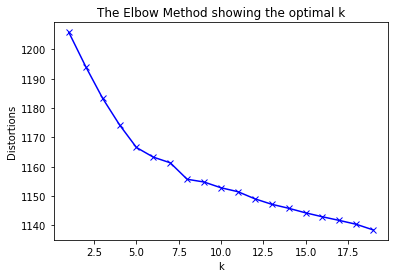

In [101]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

X = reviews_vec
K = range(1,20)

distortions = []
for k in K: 
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    kmeans.fit(X) 
    distortions.append(kmeans.inertia_)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

```
The elbow method plot above shows distortions that is slightly straight line but shows a bit of convergeance around 6, 9, and 16 so these will be the values of k that we will be using in this Homework.
```

#### Create a function to fit k-Mean model, to print top 10 common words from each cluster, and to plot wordcloud for each cluster.

In [102]:
from wordcloud import WordCloud

def wordcloud_plt(k, subplt_row, subplt_col):
    model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    model.fit(X)
    col_name = 'cluster_k' + str(k)
    df[col_name] = model.labels_

    print("Top words per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    words = tfv.get_feature_names_out()

    for i in range(k):
        print('Cluster', i , ': ' + ', '.join(words[ind] for ind in order_centroids[i, :10]))
        
    fig,axs = plt.subplots(subplt_row, subplt_col, figsize = (40,15))
    h, v = 0, 0

    for i in range(k):
        s = df[df[col_name] == i]
        text = s['review_txt'].str.cat(sep=' ')
        text = text.lower()
        text = ' '.join([word for word in text.split()])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        axs[h, v].imshow(wordcloud, interpolation="bilinear")
        axs[h, v].set_title('Cluster: {}'.format(i))
        axs[h, v].axis('off')
        if v == subplt_col-1:
            h += 1
            v = -1
        v += 1
    plt.tight_layout

### k = 6

Top words per cluster:
Cluster 0 : kevin, hart, woody, harrelson, funny, movie, comedy, just, toronto, good
Cluster 1 : batman, movie, dark, riddler, pattinson, like, film, long, robert, bruce
Cluster 2 : movie, jurassic, film, dinosaurs, just, like, good, characters, original, world
Cluster 3 : maverick, gun, cruise, tom, movie, film, original, sequel, action, great
Cluster 4 : movie, marvel, thor, waste, just, money, bad, like, time, movies
Cluster 5 : thor, bale, movie, christian, thunder, mcu, waititi, love, taika, ragnarok


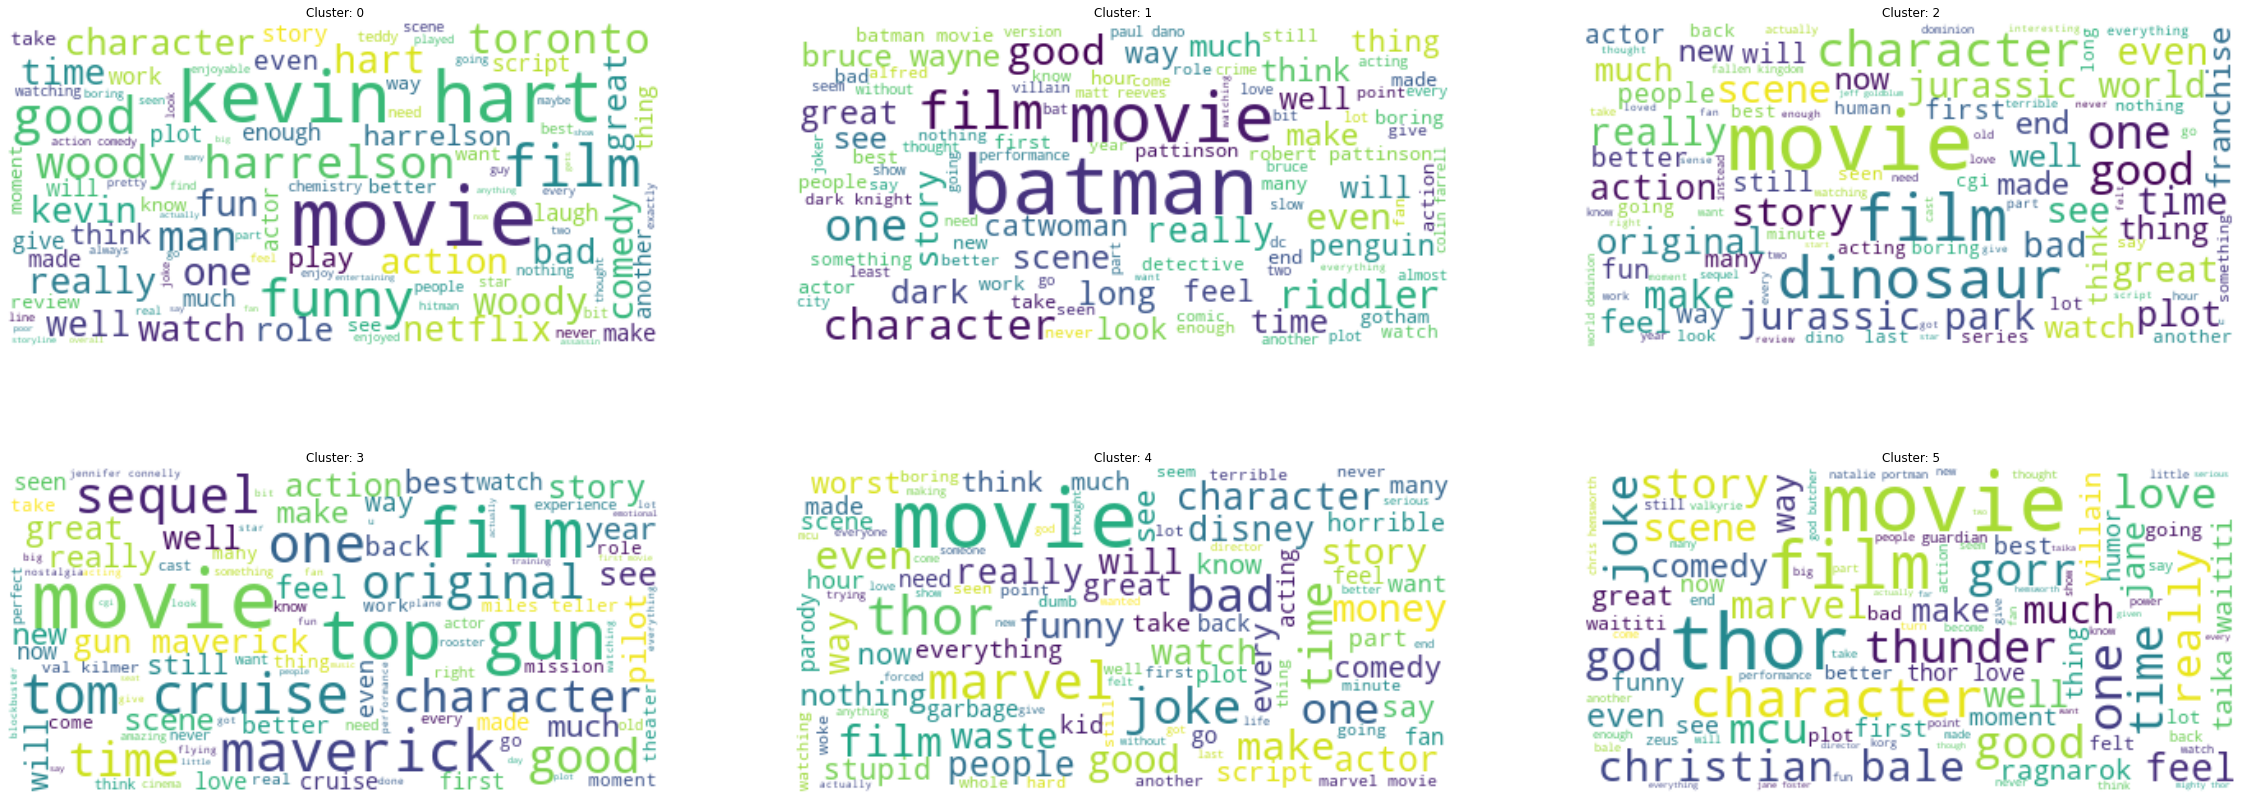

In [103]:
wordcloud_plt(6, 2, 3)

### k = 9

Top words per cluster:
Cluster 0 : kevin, hart, woody, harrelson, funny, movie, just, like, toronto, netflix
Cluster 1 : movie, dark, batman, slow, watch, super, long, knight, hour, like
Cluster 2 : jurassic, dinosaurs, movie, world, park, film, just, like, dominion, characters
Cluster 3 : thor, marvel, movie, jokes, bale, mcu, like, christian, thunder, film
Cluster 4 : hart, kevin, harrelson, movie, woody, comedy, night, watch, good, action
Cluster 5 : batman, movie, riddler, pattinson, film, like, dark, robert, just, bruce
Cluster 6 : maverick, gun, cruise, tom, film, original, sequel, mission, movie, action
Cluster 7 : movie, great, cruise, original, tom, action, gun, film, just, sequel
Cluster 8 : movie, bad, just, film, like, good, waste, money, actors, time


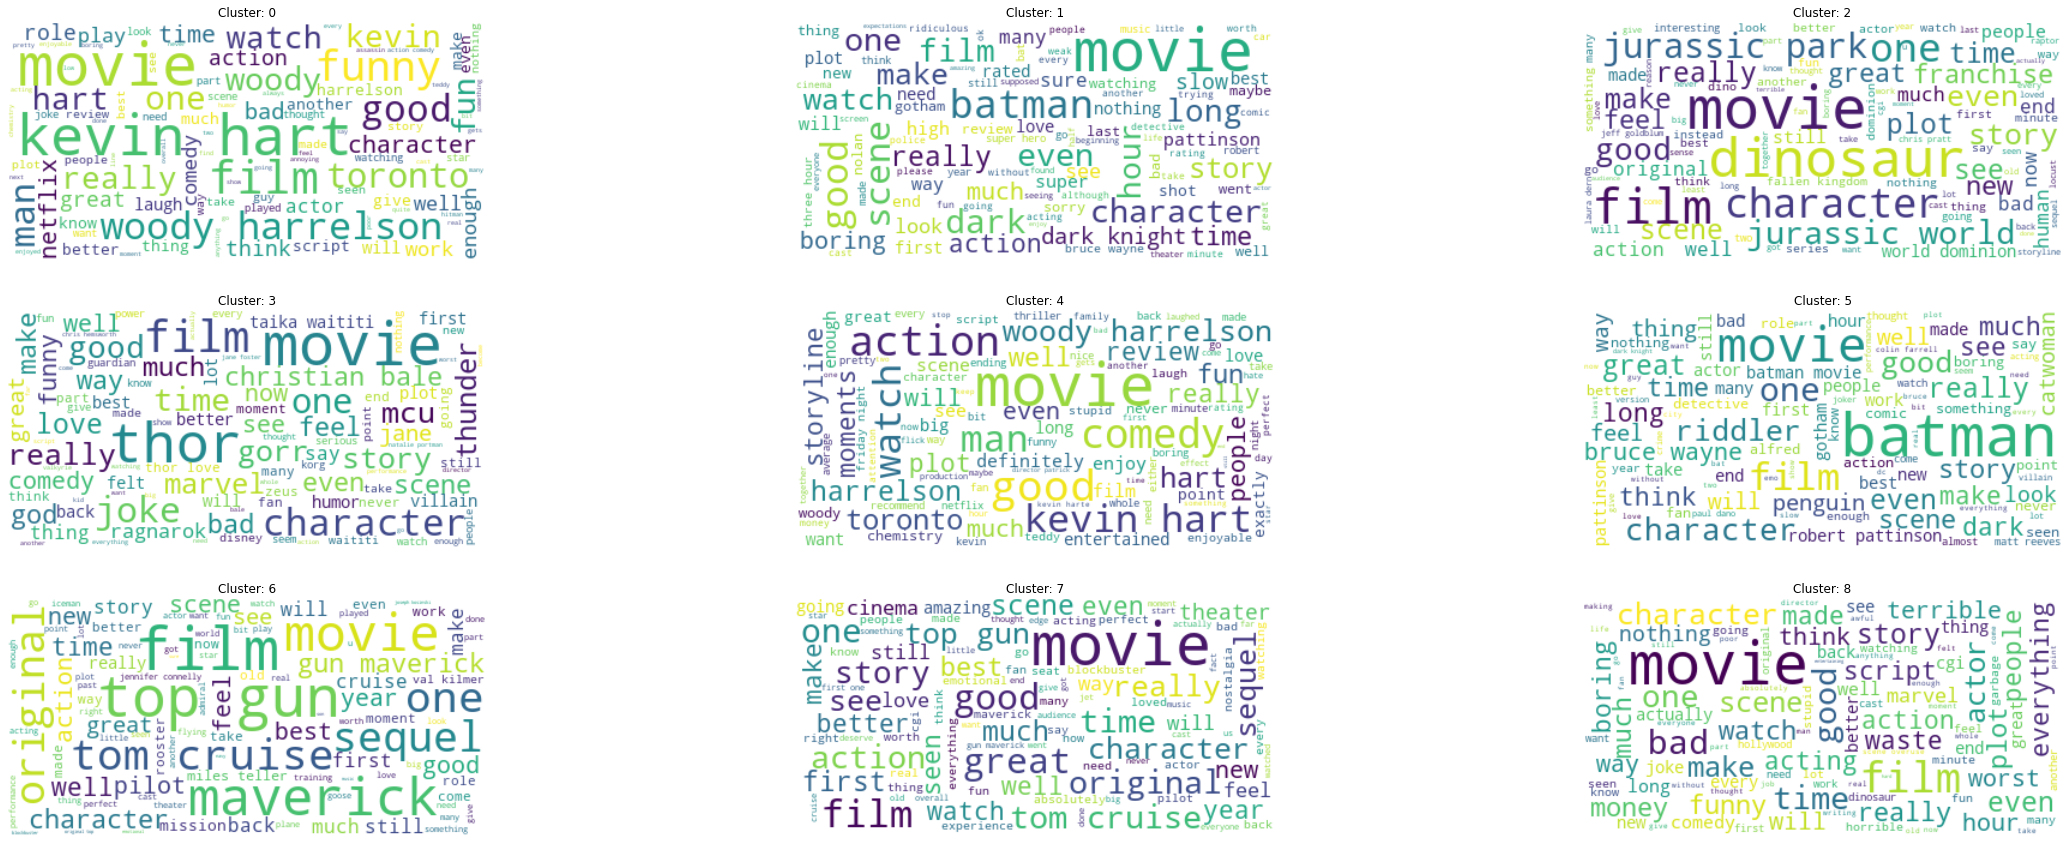

In [104]:
wordcloud_plt(9, 3, 3)

### k = 16

Top words per cluster:
Cluster 0 : funny, kevin, woody, hart, harrelson, like, movie, actor, johnson, dwayne
Cluster 1 : dark, movie, batman, knight, slow, make, good, rated, long, watch
Cluster 2 : movie, just, like, film, good, really, story, action, movies, boring
Cluster 3 : thor, movie, marvel, bale, christian, thunder, mcu, jokes, jane, love
Cluster 4 : night, harrelson, friday, hart, movie, exactly, watch, kevin, review, average
Cluster 5 : batman, movie, riddler, pattinson, film, like, dark, robert, bruce, just
Cluster 6 : maverick, gun, cruise, tom, film, teller, original, mission, sequel, miles
Cluster 7 : movie, best, seen, possible, experience, ve, original, loved, absolutely, cinema
Cluster 8 : terrible, movie, actors, acting, like, bad, script, mess, characters, just
Cluster 9 : hart, kevin, woody, harrelson, movie, comedy, like, just, action, funny
Cluster 10 : cruise, gun, tom, maverick, movie, film, original, action, sequel, good
Cluster 11 : waste, money, joke, marvel

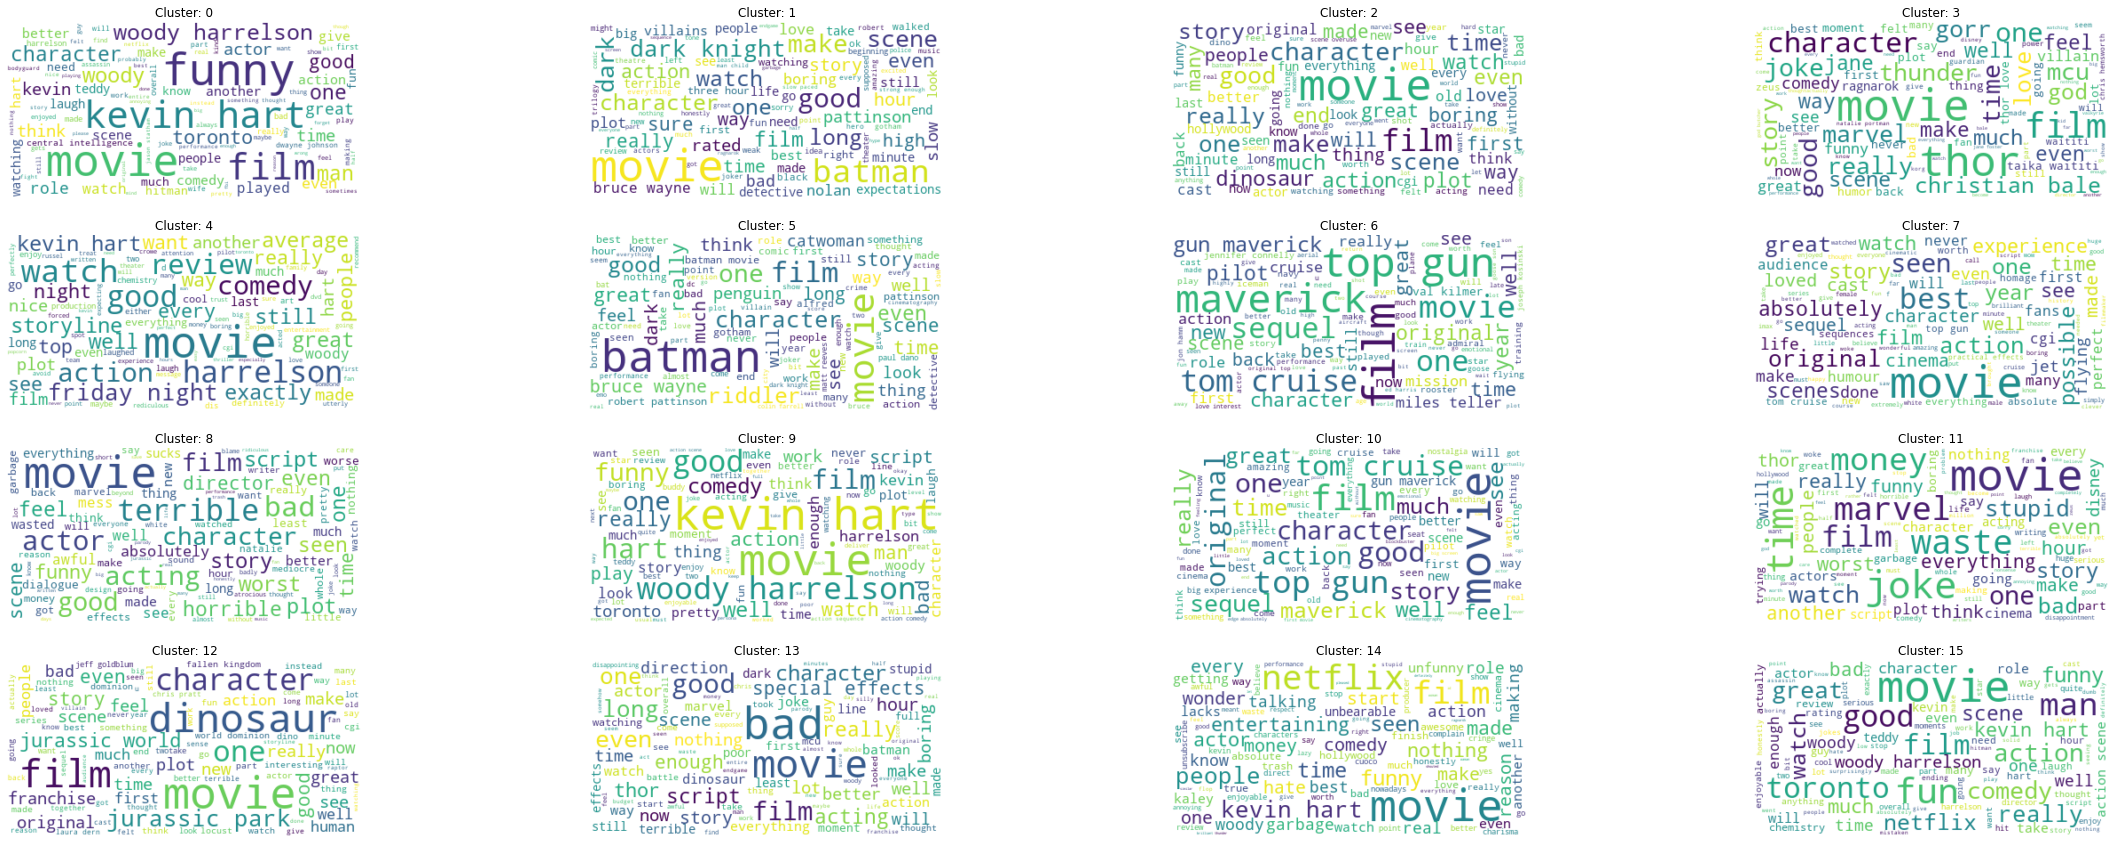

In [105]:
wordcloud_plt(16, 4, 4)

In [106]:
df.head()

movie_name                                       review_title  \
0  Thor: Love and Thunder                                Enjoyable but empty   
1  Thor: Love and Thunder                           Nearly a 2-hour SNL skit   
2  Thor: Love and Thunder  Christian bales great performance wasted in a ...   
3  Thor: Love and Thunder                    Bale good, the rest kinda weak.   
4  Thor: Love and Thunder                             Very very disappointed   

                                          review_txt  cluster_k6  cluster_k9  \
0  Thor: Love and Thunder does attempt to explore...           5           3   
1  ...Well, maybe not SNL-esque throughout the fu...           4           3   
2  Christian Bale is great, Russell Crowe has a g...           5           8   
3  Fine seems to cover it, Disney has become fine...           4           8   
4  I'm a huge marvel fanboy, and hardly ever have...           4           3   

   cluster_k16  
0            3  
1            3  
2           13  
3           11  
4           11

---
Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:
1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference.<br> Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.


In [107]:
from nltk.sentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
# nltk.download('names')

sentiAnalyzer = SentimentIntensityAnalyzer()

In [108]:

sentiAnalyzer.polarity_scores('love')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}

In [109]:
polarityScore = []

for index, row in df.iterrows():
    score = sentiAnalyzer.polarity_scores(row['review_txt'])
    polarityScore.append(score['compound'])

In [110]:
df['polarity_score'] = polarityScore
df.head()

movie_name                                       review_title  \
0  Thor: Love and Thunder                                Enjoyable but empty   
1  Thor: Love and Thunder                           Nearly a 2-hour SNL skit   
2  Thor: Love and Thunder  Christian bales great performance wasted in a ...   
3  Thor: Love and Thunder                    Bale good, the rest kinda weak.   
4  Thor: Love and Thunder                             Very very disappointed   

                                          review_txt  cluster_k6  cluster_k9  \
0  Thor: Love and Thunder does attempt to explore...           5           3   
1  ...Well, maybe not SNL-esque throughout the fu...           4           3   
2  Christian Bale is great, Russell Crowe has a g...           5           8   
3  Fine seems to cover it, Disney has become fine...           4           8   
4  I'm a huge marvel fanboy, and hardly ever have...           4           3   

   cluster_k16  polarity_score  
0            3          0.9722  
1            3         -0.9602  
2           13         -0.5991  
3           11          0.5267  
4           11          0.7991

---
2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

In [151]:
import seaborn as sns

def clusterScore(k):
    col_name = 'cluster_k' + str(k)
    cluster_Scores = df[[col_name,'polarity_score']]
    cluster_Group_Scores = cluster_Scores.groupby(col_name).agg({'polarity_score': ['mean', 'median', 'min', 'max']})
    print(cluster_Group_Scores)

    sns.set(rc={'figure.figsize':(40,12)})
    ax = sns.swarmplot(x=col_name, y='polarity_score', s=3, data=df)

           polarity_score                         
                     mean   median     min     max
cluster_k6                                        
0                0.367425  0.76780 -0.9941  0.9969
1                0.234004  0.73255 -0.9988  0.9995
2                0.284045  0.66290 -0.9985  0.9996
3                0.896784  0.97710 -0.8833  0.9998
4               -0.090004 -0.22750 -0.9942  0.9884
5                0.577301  0.90860 -0.9479  0.9993


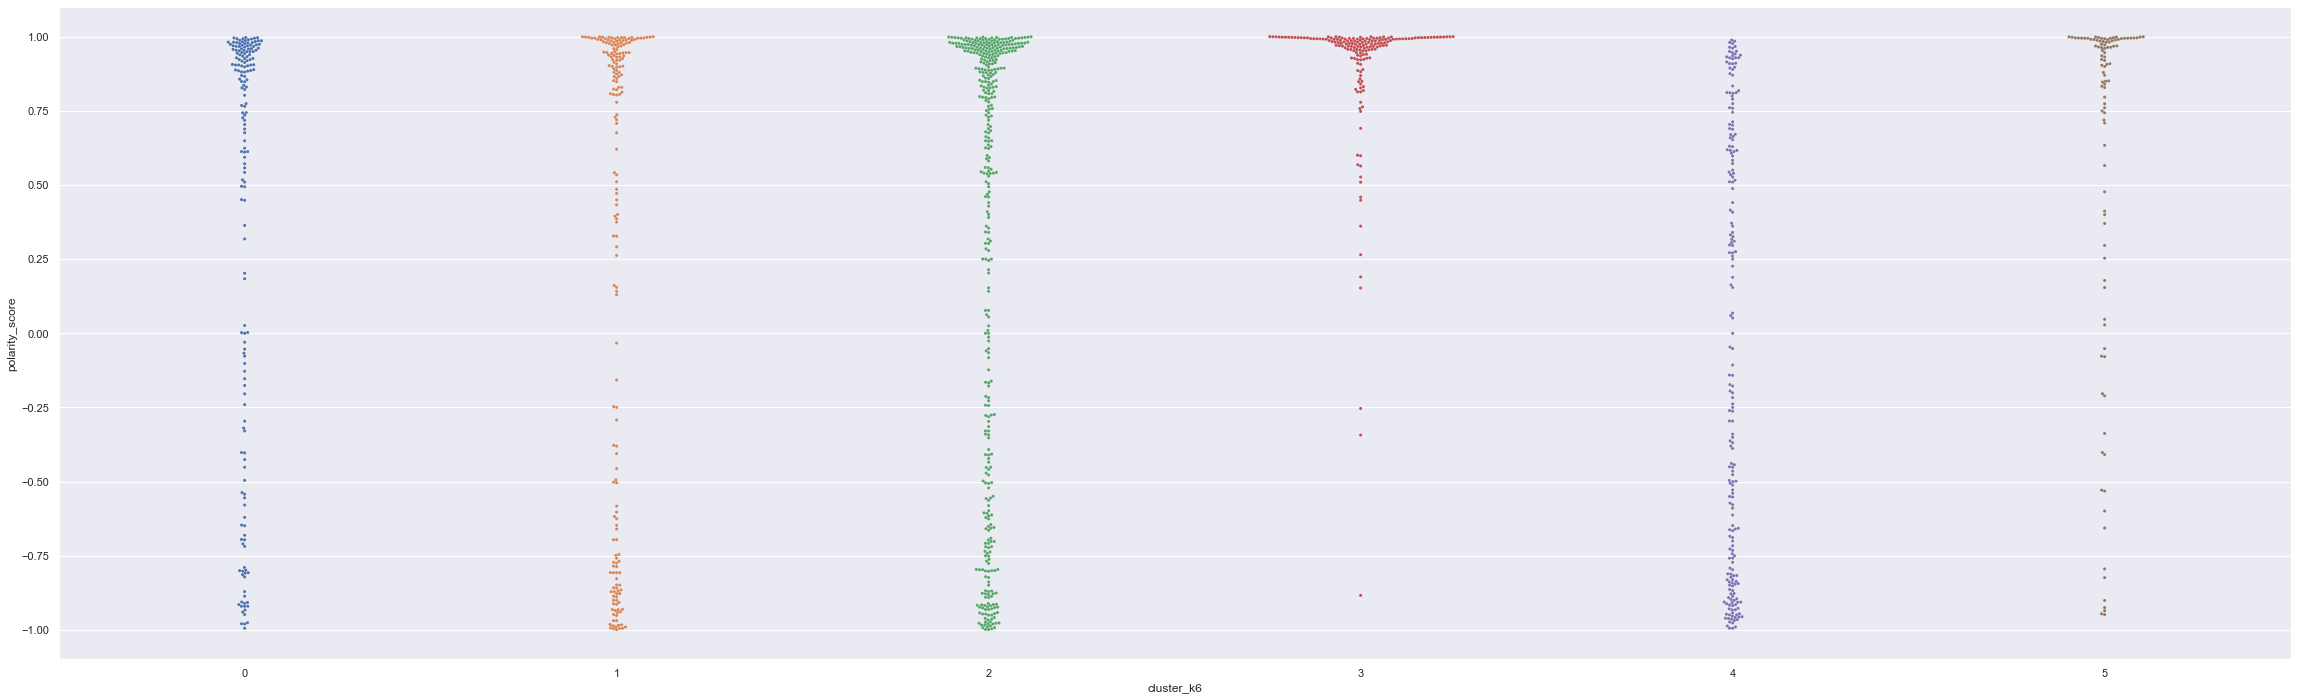

In [152]:
clusterScore(6)

           polarity_score                        
                     mean  median     min     max
cluster_k9                                       
0                0.384657  0.7880 -0.9798  0.9969
1                0.159987  0.3400 -0.9857  0.9914
2                0.238887  0.7183 -0.9985  0.9996
3                0.367154  0.7309 -0.9939  0.9993
4                0.321479  0.7037 -0.9941  0.9961
5                0.212919  0.8029 -0.9988  0.9995
6                0.929375  0.9867 -0.8833  0.9998
7                0.812286  0.9595 -0.9066  0.9990
8                0.001822  0.0000 -0.9942  0.9953


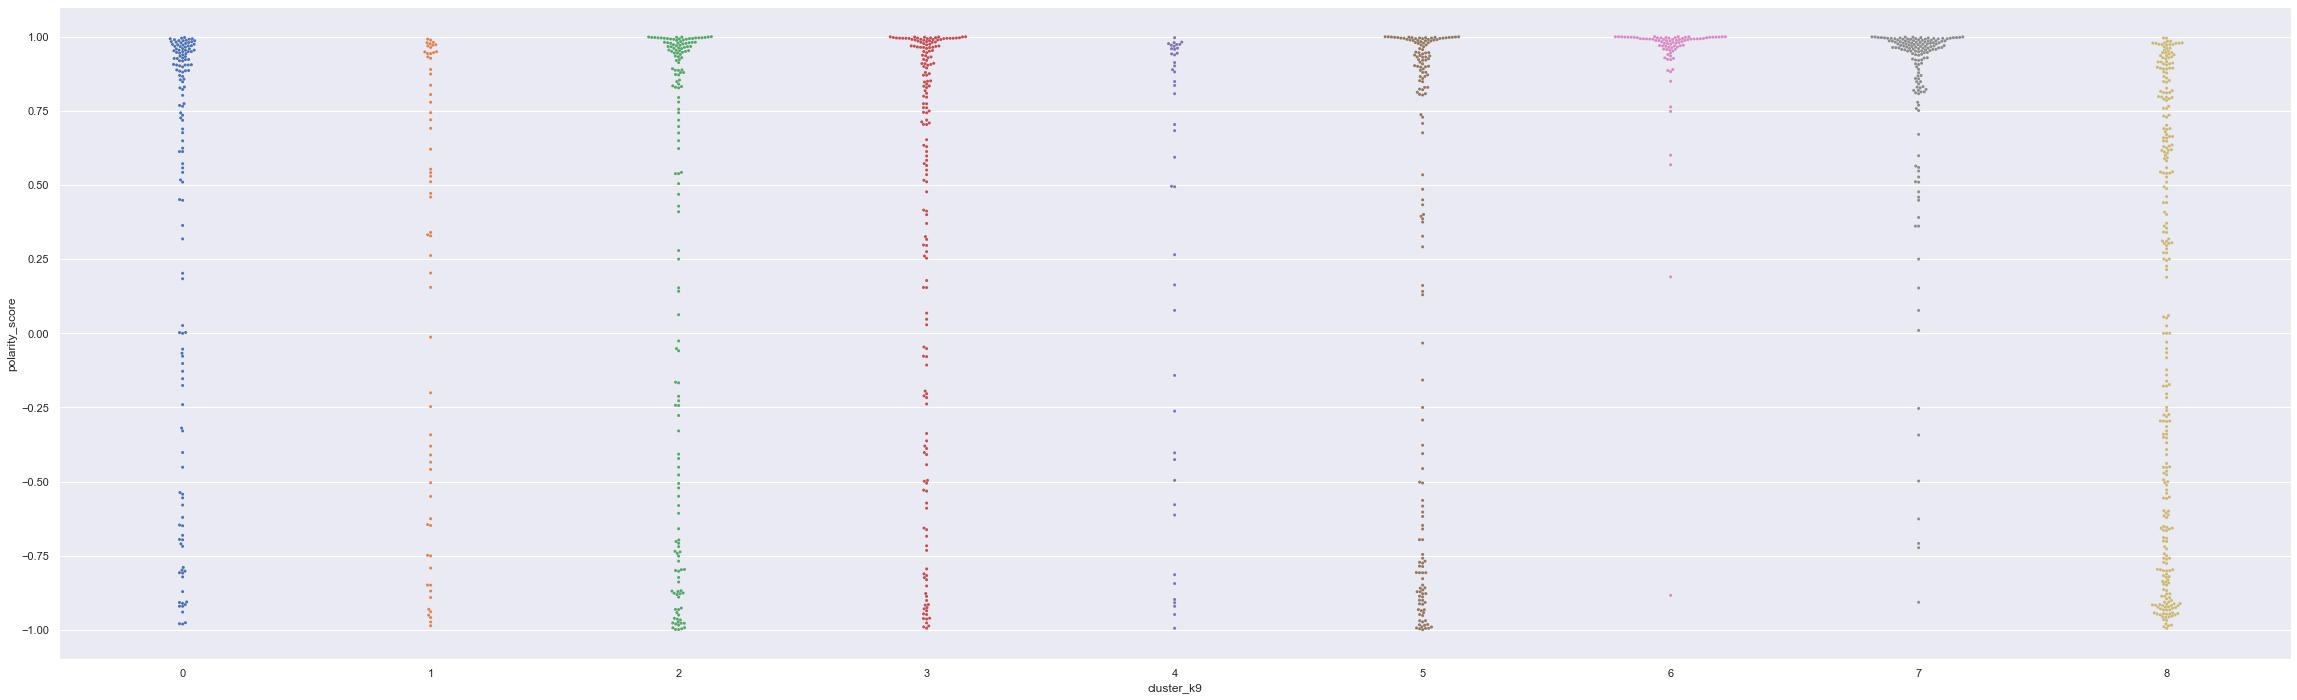

In [153]:
clusterScore(9)

            polarity_score                         
                      mean   median     min     max
cluster_k16                                        
0                 0.391807  0.74685 -0.9798  0.9945
1                 0.072262  0.26210 -0.9857  0.9879
2                 0.262175  0.59940 -0.9893  0.9985
3                 0.433820  0.79580 -0.9939  0.9993
4                 0.304225  0.90685 -0.9477  0.9778
5                 0.245124  0.80630 -0.9988  0.9995
6                 0.954984  0.99130  0.6003  0.9994
7                 0.674426  0.91000 -0.9066  0.9966
8                -0.254404 -0.61315 -0.9942  0.9144
9                 0.425169  0.76500 -0.9396  0.9896
10                0.887959  0.97515 -0.8833  0.9998
11               -0.129186 -0.35060 -0.9734  0.9669
12                0.272226  0.79460 -0.9985  0.9996
13               -0.320222 -0.56925 -0.9650  0.9773
14                0.001945 -0.02670 -0.9179  0.9610
15                0.494711  0.90540 -0.9941  0.9969


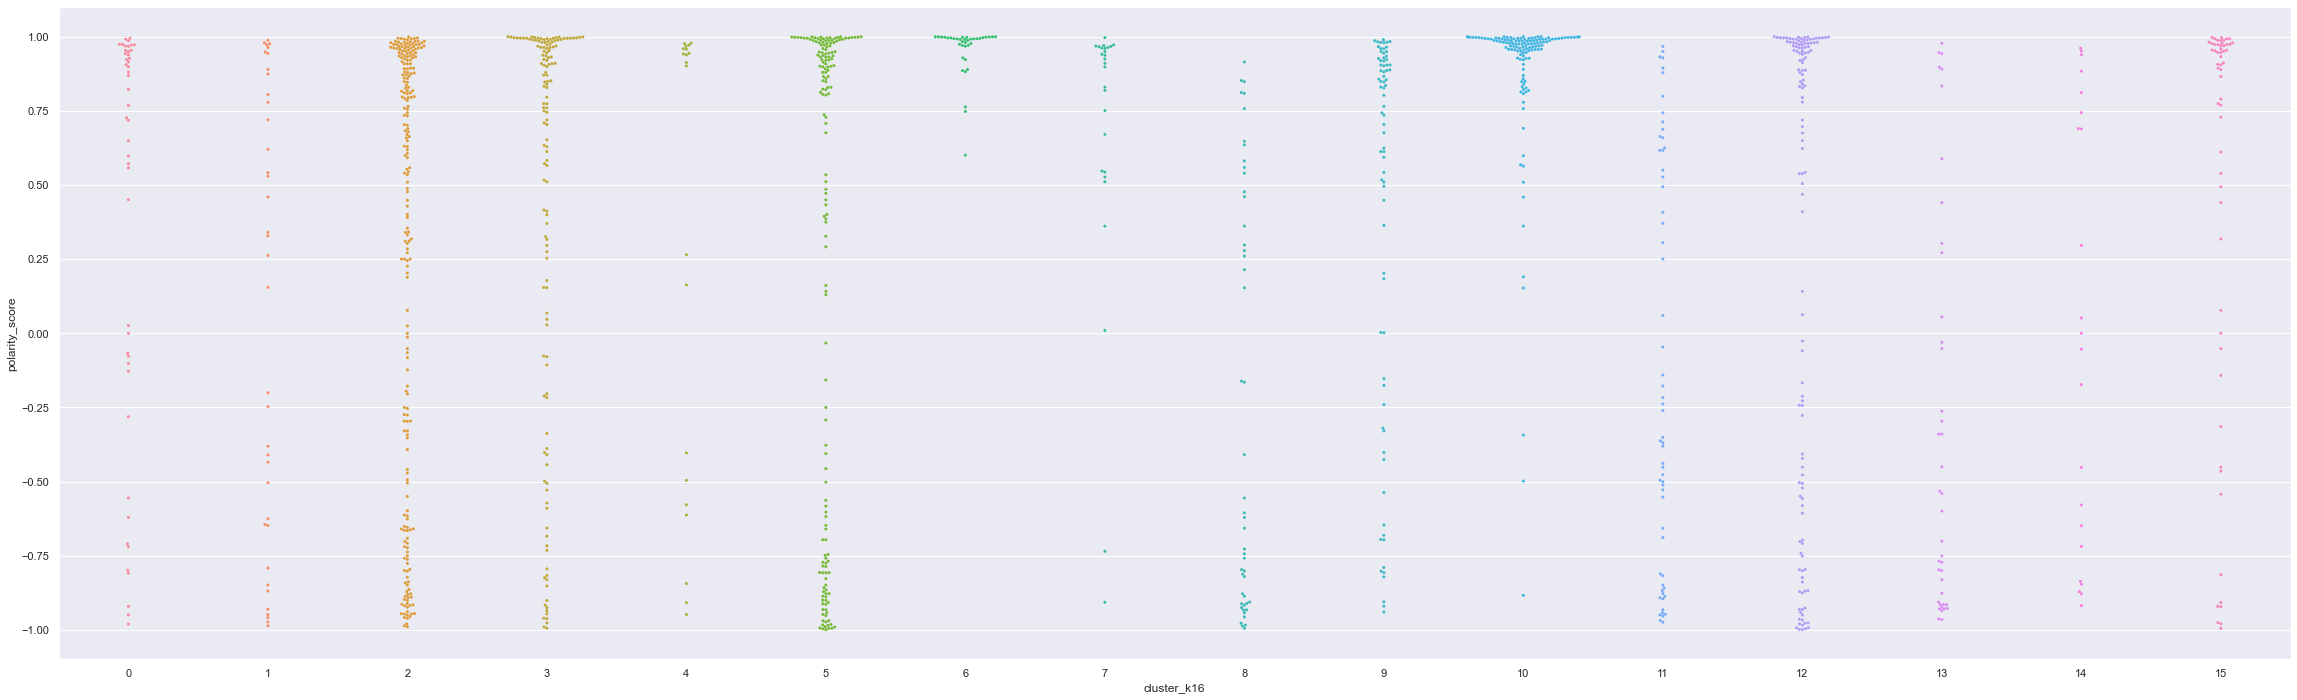

In [154]:
clusterScore(16)

---
3.	For extra credit, analyze sentiment of chunks as follows:
    - Take the chunks from homework 5, and in Python, run each chunk individually through your sentiment analyzer that you used in question 1. If the chunk registers a nonneutral sentiment, save it in a tabular format (the chunk, the sentiment score).
    - Now sort the table twice, once to show the highest negative-sentiment-scoring chunks at the top and again to show the highest positive-sentiment-scoring chunks at the top. Examine the upper portions of both sorted lists, to identify any trends, and explain what you see. 


In [156]:
# Returns the tagged version of the review
def getMovieReviewTags(reviewSentence):	
    nps = []
    # NOTE: For purposes of the exercise I'm treating
    # the grammar variable as a global so that the regular
    # expression patterns can be change it as needed
    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(reviewSentence)
    # loop through the trees produced and pull out only the 
    # NP subtrees
    for subtree in tree.subtrees():
        if subtree.label() == 'NP':
            t = subtree
            t = ' '.join(word for word, tag in t.leaves())
            nps.append(t)
    return nps

# Returns the NP chunked review results
def processReviewText(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    sentences = [getMovieReviewTags(sent) for sent in sentences]
    return sentences

In [157]:
grammar = """
    NP:    {<DT><WP><VBP>*<RB>*<VBN><IN><NN>}
           {<NN|NNS|NNP|NNPS><IN>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS><CC>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS>+}
    """   
df['proc_review2'] = df['review_txt'].apply(processReviewText)
df.head()

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\puri.rudick/nltk_data'
    - 'c:\\Users\\puri.rudick\\Anaconda3\\envs\\puri\\nltk_data'
    - 'c:\\Users\\puri.rudick\\Anaconda3\\envs\\puri\\share\\nltk_data'
    - 'c:\\Users\\puri.rudick\\Anaconda3\\envs\\puri\\lib\\nltk_data'
    - 'C:\\Users\\puri.rudick\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [ ]:
def sentiment_scores(sentence,printScores=True): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    
    if (printScores):
        print("Overall sentiment dictionary is : ", sentiment_dict) 
        print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
        print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
        print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
        print("Sentence Overall Rated As", end = " ") 
  
        # decide sentiment as positive, negative and neutral 
        if sentiment_dict['compound'] >= 0.05 : 
            print("Positive") 
  
        elif sentiment_dict['compound'] <= - 0.05 : 
            print("Negative") 
  
        else : 
            print("Neutral") 

    return sentiment_dict['compound']


    
def getChunkedSentimentScores(reviewChunk,printScores=False):

    termList = []
    scoreList = []

    for terms in reviewChunk:
        for term in terms:
            termStr = ' '.join(term)
            sent_score = sentiment_scores(termStr,printScores)

            if sent_score >= 0.05 : 
                termList.append(termStr)
                scoreList.append(sent_score)
            elif sent_score <= - 0.05 : 
                termList.append(termStr)
                scoreList.append(sent_score)

    return termList, scoreList

In [ ]:
# get the chunked sentiment analysis results. Get the score and the list of terms
termList, scoreList = getChunkedSentimentScores(df['proc_user_review2'].tolist())

# build out a data frame for easy analysis
df_sent = pd.DataFrame({'TermsStr': termList, 'Sentiment_Score': scoreList})

# double check the data frame to make sure we have results
df_sent.head()